In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from DataTransformation import LowPassFilter, PrincipalComponentAnalysis
from TemporalAbstraction import NumericalAbstraction
from FrequencyAbstraction import FourierTransformation
from sklearn.cluster import KMeans

In [2]:
df = pd.read_pickle("../../data/interim/02_outliers_removed_chauvenets.pkl")

In [3]:
predictor_columns = list(df.columns[:6])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9005 non-null   float64
 1   acc_y        8998 non-null   float64
 2   acc_z        8999 non-null   float64
 3   gyr_x        8984 non-null   float64
 4   gyr_y        8938 non-null   float64
 5   gyr_z        8945 non-null   float64
 6   participant  9009 non-null   object 
 7   label        9009 non-null   object 
 8   category     9009 non-null   object 
 9   set          9009 non-null   int32  
dtypes: float64(6), int32(1), object(3)
memory usage: 739.0+ KB


In [5]:
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

In [6]:
for col in predictor_columns:
    df[col] = df[col].interpolate()

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9009 non-null   float64
 1   acc_y        9009 non-null   float64
 2   acc_z        9009 non-null   float64
 3   gyr_x        9009 non-null   float64
 4   gyr_y        9009 non-null   float64
 5   gyr_z        9009 non-null   float64
 6   participant  9009 non-null   object 
 7   label        9009 non-null   object 
 8   category     9009 non-null   object 
 9   set          9009 non-null   int32  
dtypes: float64(6), int32(1), object(3)
memory usage: 739.0+ KB


In [7]:
for s in df["set"].unique():
    duration = df[df["set"] == s].index[-1] - df[df["set"] == s].index[0]
    df.loc[(df["set"] == s), "duration"] = duration.seconds

duration_df = df.groupby(["category"])["duration"].mean()

duration_df[0] / 5  # avg duration of a single repetition for heavy sets
duration_df[1] / 10

2.4942528735632186

In [8]:
duration_df[0] / 5  # avg duration of a single repetition for heavy sets

2.9487001733102254

In [9]:
duration_df[1] / 10  # avg duration of a single repetition for medium sets

2.4942528735632186

In [10]:
duration_df

category
heavy       14.743501
medium      24.942529
sitting     33.000000
standing    39.000000
Name: duration, dtype: float64

In [11]:
df_lowpass = df.copy()
LowPass = LowPassFilter()

fs = 1000 / 200
cutoff = 1.3

In [12]:
df_lowpass = LowPass.low_pass_filter(df_lowpass, "acc_y", fs, cutoff, order=5)

In [13]:
subset = df_lowpass[df_lowpass["set"] == 42]

In [14]:
print(subset["label"][0])

dead


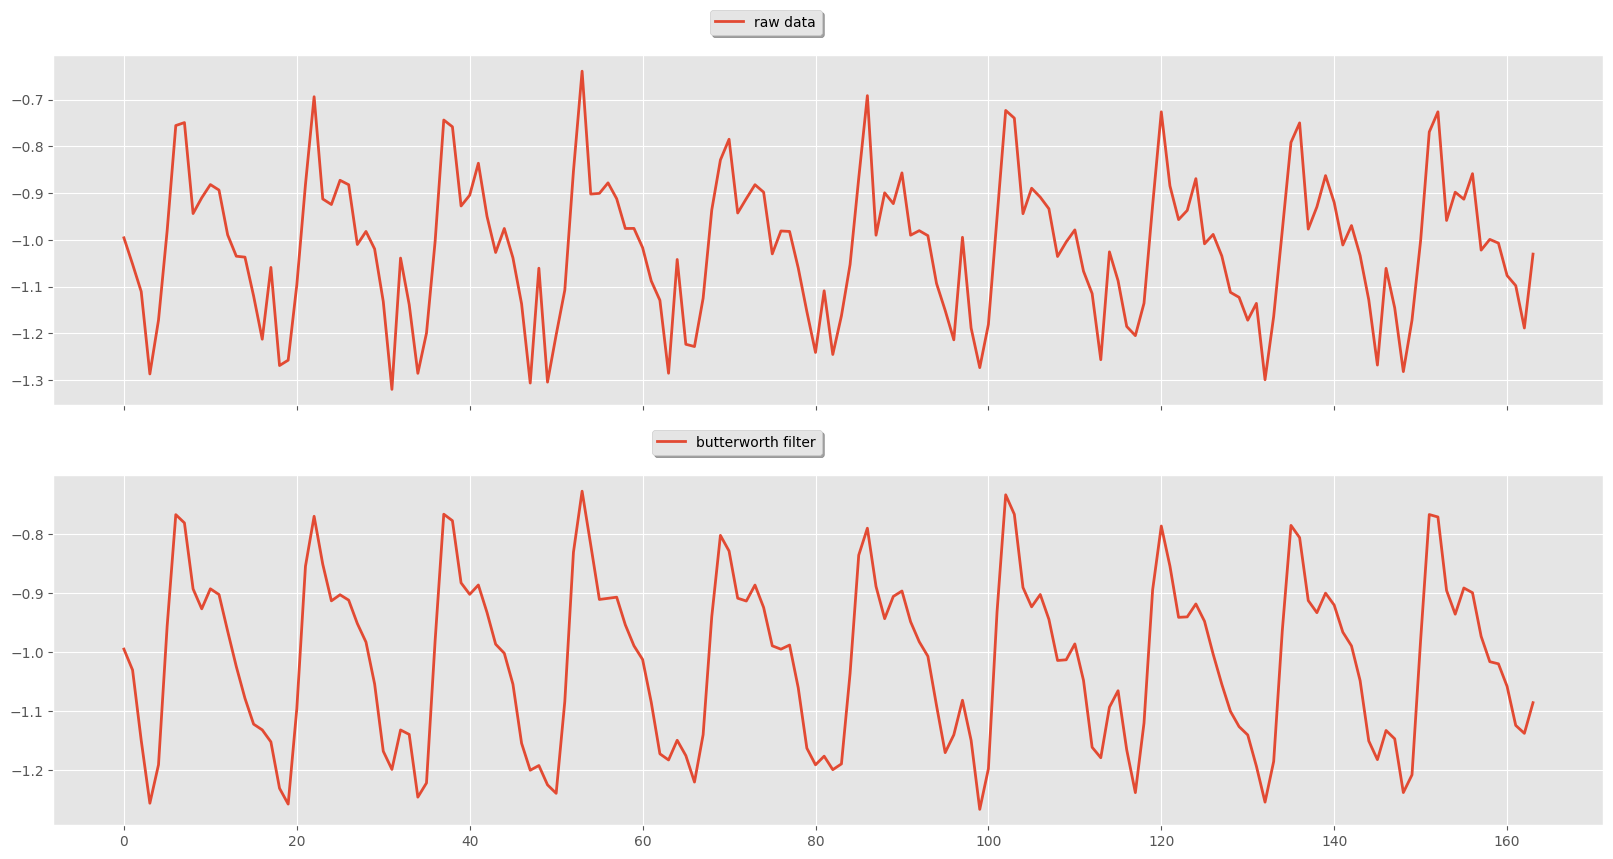

In [15]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 10))
ax[0].plot(subset["acc_y"].reset_index(drop=True), label="raw data")
ax[1].plot(subset["acc_y_lowpass"].reset_index(drop=True), label="butterworth filter")
ax[0].legend(
    loc="upper right", bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True
)
ax[1].legend(
    loc="upper right", bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True
)

In [16]:
for col in predictor_columns:
    df_lowpass = LowPass.low_pass_filter(df_lowpass, col, fs, cutoff, order=5)
    df_lowpass[col] = df_lowpass[col + "_lowpass"]
    del df_lowpass[col + "_lowpass"]

In [26]:
cutoff = 1.3  # chosen by tweaking different values and checking

In [27]:
for col in predictor_columns:
    df_lowpass = LowPass.low_pass_filter(df_lowpass, col, fs, cutoff, order=5) #new col added
    df_lowpass[col] = df_lowpass[col + "_lowpass"]
    del df_lowpass[col + "_lowpass"]

In [28]:
df_lowpass

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration
epoch (ms),,,,,,,,,,,
2019-01-11 15:08:05.200,0.013507,0.976994,-0.071005,-1.884434,2.438116,0.938372,B,bench,heavy,30,16.0
2019-01-11 15:08:05.400,0.008033,0.975262,-0.065866,1.536069,0.442310,-1.065650,B,bench,heavy,30,16.0
2019-01-11 15:08:05.600,-0.009115,0.964123,-0.072978,4.245043,-2.034491,-1.046461,B,bench,heavy,30,16.0
2019-01-11 15:08:05.800,-0.023861,0.960097,-0.085242,2.777774,-3.498659,0.601113,B,bench,heavy,30,16.0
2019-01-11 15:08:06.000,-0.020992,0.965676,-0.094796,0.923234,-1.313732,-2.085027,B,bench,heavy,30,16.0
...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.045042,-0.976448,-0.061903,2.748413,-4.307783,0.251154,E,row,medium,90,19.0
2019-01-20 17:33:27.200,-0.041659,-1.037401,-0.060441,-3.112396,-2.260935,1.311641,E,row,medium,90,19.0
2019-01-20 17:33:27.400,-0.047054,-1.050451,-0.066066,-0.430802,-1.881234,1.141422,E,row,medium,90,19.0


In [29]:
df_pca = df_lowpass.copy()
PCA = PrincipalComponentAnalysis()
pc_values = PCA.determine_pc_explained_variance(df_pca, predictor_columns)

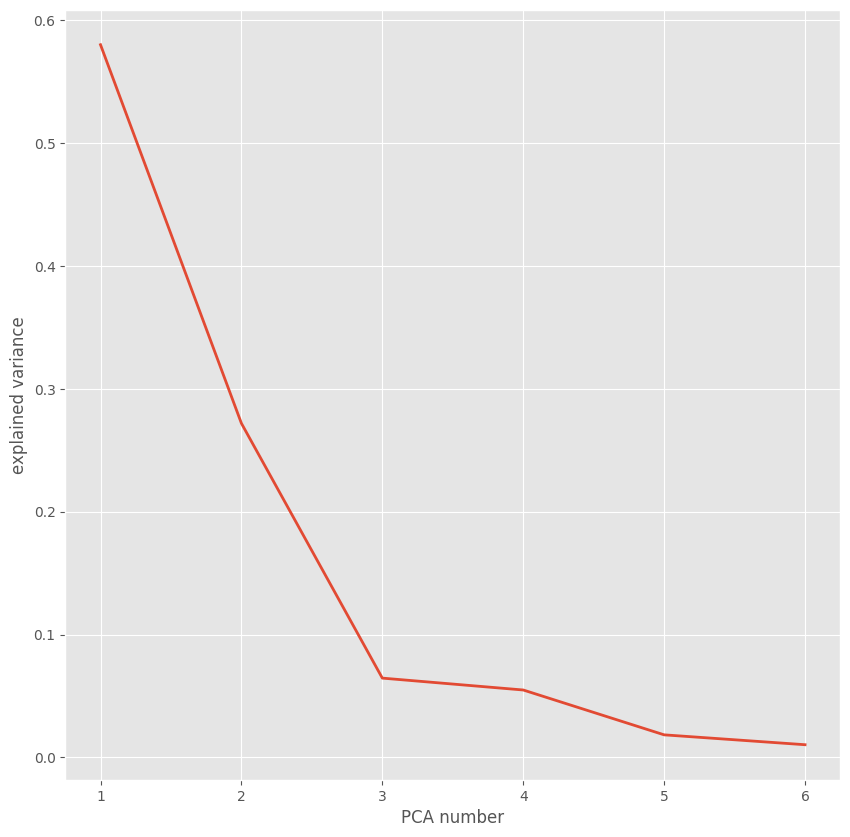

In [30]:
plt.figure(figsize=(10, 10))
plt.plot(range(1, len(predictor_columns) + 1), pc_values)
plt.xlabel("PCA number")
plt.ylabel("explained variance")
plt.show()

In [31]:
df_pca = PCA.apply_pca(df_pca, predictor_columns, 3)  # the features have been

In [32]:
subset = df_pca[df_pca["set"] == 65]

<AxesSubplot: xlabel='epoch (ms)'>

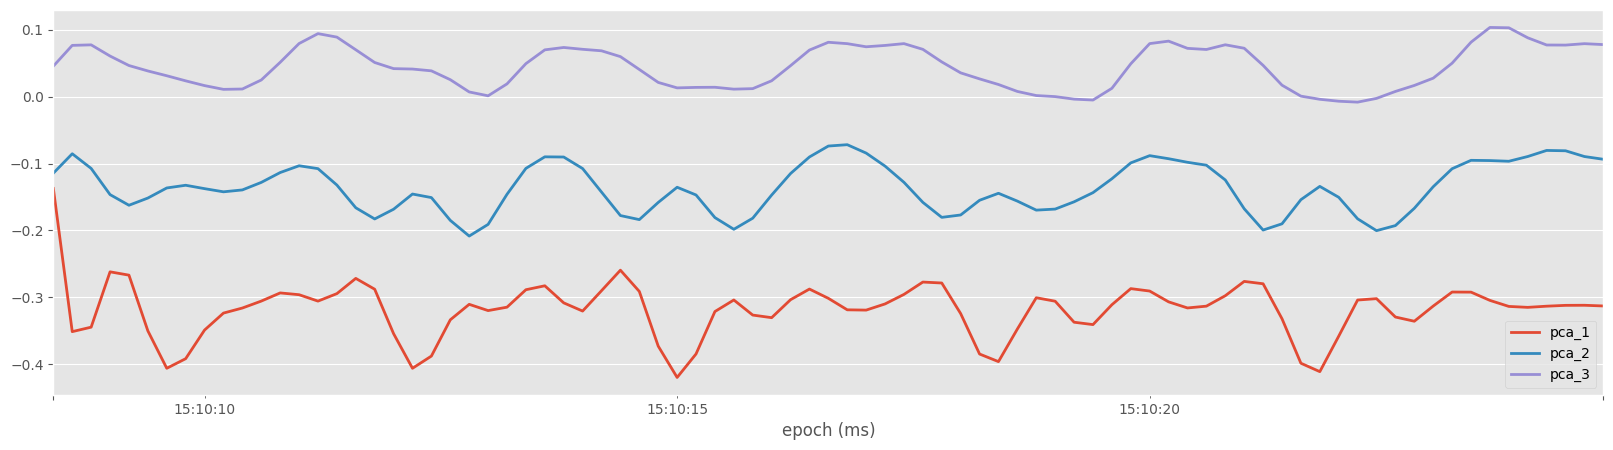

In [33]:
subset[["pca_1", "pca_2", "pca_3"]].plot()

In [35]:
pc_values

array([0.58001734, 0.27189314, 0.06453441, 0.05486333, 0.01836735,
       0.01032443])

In [36]:
df_pca

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration,pca_1,pca_2,pca_3
epoch (ms),,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013507,0.976994,-0.071005,-1.884434,2.438116,0.938372,B,bench,heavy,30,16.0,-0.316097,-0.075634,0.070811
2019-01-11 15:08:05.400,0.008033,0.975262,-0.065866,1.536069,0.442310,-1.065650,B,bench,heavy,30,16.0,-0.315763,-0.073733,0.070368
2019-01-11 15:08:05.600,-0.009115,0.964123,-0.072978,4.245043,-2.034491,-1.046461,B,bench,heavy,30,16.0,-0.313549,-0.081333,0.066011
2019-01-11 15:08:05.800,-0.023861,0.960097,-0.085242,2.777774,-3.498659,0.601113,B,bench,heavy,30,16.0,-0.313790,-0.091208,0.060362
2019-01-11 15:08:06.000,-0.020992,0.965676,-0.094796,0.923234,-1.313732,-2.085027,B,bench,heavy,30,16.0,-0.315721,-0.096035,0.062802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.045042,-0.976448,-0.061903,2.748413,-4.307783,0.251154,E,row,medium,90,19.0,0.345673,-0.147468,-0.052026
2019-01-20 17:33:27.200,-0.041659,-1.037401,-0.060441,-3.112396,-2.260935,1.311641,E,row,medium,90,19.0,0.366651,-0.147990,-0.059170
2019-01-20 17:33:27.400,-0.047054,-1.050451,-0.066066,-0.430802,-1.881234,1.141422,E,row,medium,90,19.0,0.370572,-0.152676,-0.058625


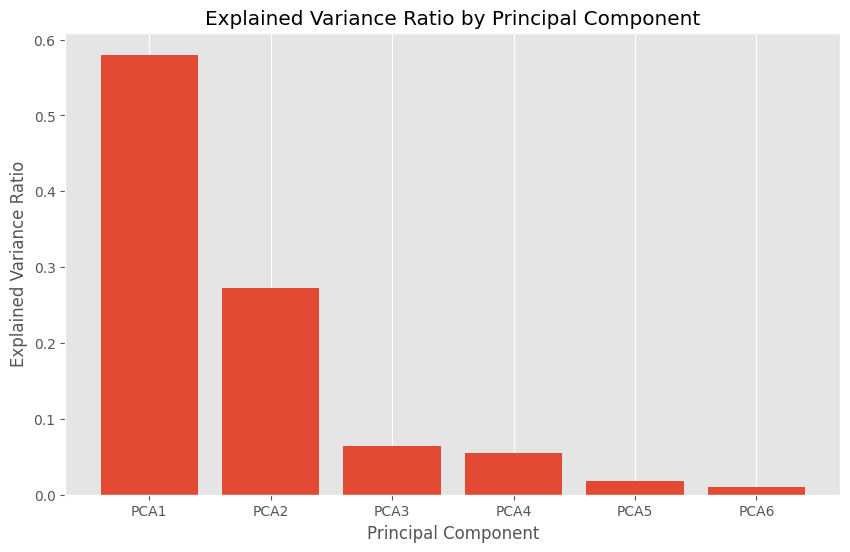

In [38]:
plt.figure(figsize=(10, 6))
plt.bar(np.arange(1, len(pc_values) + 1), pc_values)
plt.title('Explained Variance Ratio by Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(np.arange(1, len(pc_values) + 1), [f'PCA{i}' for i in range(1, len(pc_values) + 1)])
plt.grid(axis='y')
plt.show()

array([<AxesSubplot: xlabel='epoch (ms)'>,
       <AxesSubplot: xlabel='epoch (ms)'>], dtype=object)

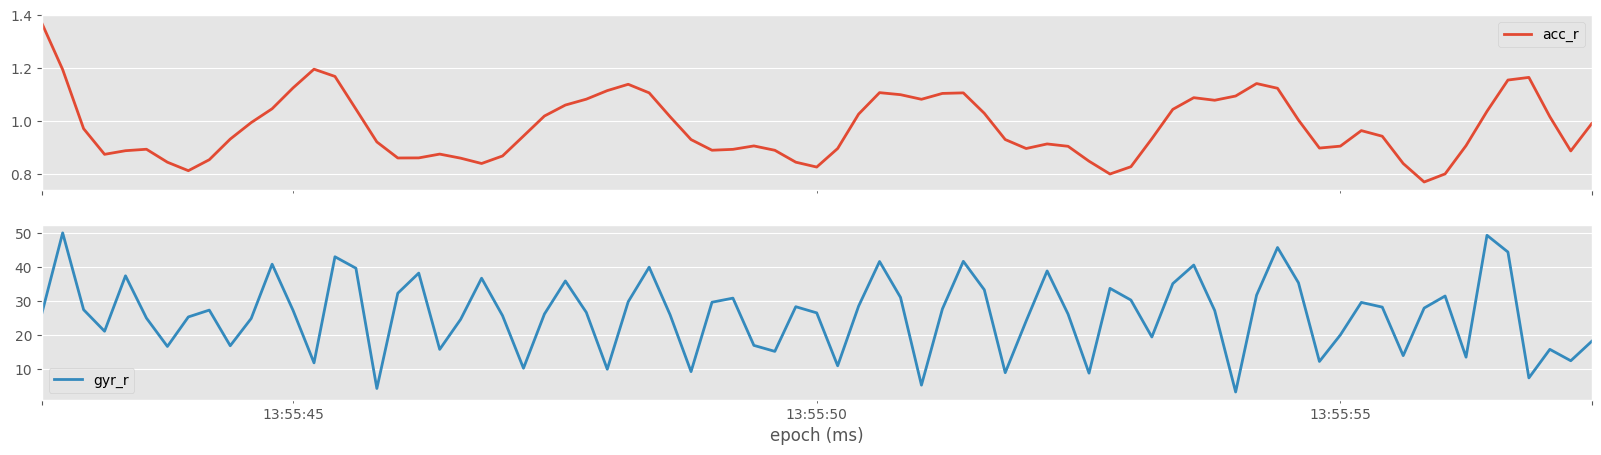

In [39]:
df_squared = df_pca.copy()
acc_r = df_squared["acc_x"] ** 2 + df_squared["acc_y"] ** 2 + df_squared["acc_z"] ** 2
gyr_r = df_squared["gyr_x"] ** 2 + df_squared["gyr_y"] ** 2 + df_squared["gyr_z"] ** 2

df_squared["acc_r"] = np.sqrt(acc_r)
df_squared["gyr_r"] = np.sqrt(gyr_r)

subset = df_squared[df_squared["set"] == 14]
subset[["acc_r", "gyr_r"]].plot(subplots=True)

In [42]:
df_temporal = df_squared.copy()
NumAbs = NumericalAbstraction()
predictor_columns = predictor_columns + ["acc_r", "gyr_r"]
ws = int(1000 / 200)

df_temporal_list = []
for s in df_temporal["set"].unique():
    subset = df_temporal[df_temporal["set"] == s].copy()
    for col in predictor_columns:
        subset = NumAbs.abstract_numerical(subset, [col], ws, "mean")
        subset = NumAbs.abstract_numerical(subset, [col], ws, "std")
    df_temporal_list.append(subset)  # list type
pd.concat(df_temporal_list)

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_x_temp_mean_ws_5,gyr_x_temp_std_ws_5,gyr_y_temp_mean_ws_5,gyr_y_temp_std_ws_5,gyr_z_temp_mean_ws_5,gyr_z_temp_std_ws_5,acc_r_temp_mean_ws_5,acc_r_temp_std_ws_5,gyr_r_temp_mean_ws_5,gyr_r_temp_std_ws_5
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013507,0.976994,-0.071005,-1.884434,2.438116,0.938372,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.400,0.008033,0.975262,-0.065866,1.536069,0.442310,-1.065650,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.600,-0.009115,0.964123,-0.072978,4.245043,-2.034491,-1.046461,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.800,-0.023861,0.960097,-0.085242,2.777774,-3.498659,0.601113,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:06.000,-0.020992,0.965676,-0.094796,0.923234,-1.313732,-2.085027,B,bench,heavy,30,...,1.519537,2.047164,-0.793291,2.054222,-0.531531,1.132014,0.971764,0.005968,3.420765,1.100621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.045042,-0.976448,-0.061903,2.748413,-4.307783,0.251154,E,row,medium,90,...,-11.872268,18.126048,0.637138,5.466620,7.178283,6.238822,1.080693,0.123203,19.221407,14.858747
2019-01-20 17:33:27.200,-0.041659,-1.037401,-0.060441,-3.112396,-2.260935,1.311641,E,row,medium,90,...,-4.927213,12.681738,-1.465578,3.942474,4.393673,5.007115,1.100968,0.105176,11.711085,10.489088
2019-01-20 17:33:27.400,-0.047054,-1.050451,-0.066066,-0.430802,-1.881234,1.141422,E,row,medium,90,...,0.739669,4.371090,-3.021602,1.519662,1.921967,2.119536,1.064067,0.079933,5.695834,2.614739


In [43]:
df_temporal = pd.concat(df_temporal_list)

In [44]:
df_temporal

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_x_temp_mean_ws_5,gyr_x_temp_std_ws_5,gyr_y_temp_mean_ws_5,gyr_y_temp_std_ws_5,gyr_z_temp_mean_ws_5,gyr_z_temp_std_ws_5,acc_r_temp_mean_ws_5,acc_r_temp_std_ws_5,gyr_r_temp_mean_ws_5,gyr_r_temp_std_ws_5
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013507,0.976994,-0.071005,-1.884434,2.438116,0.938372,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.400,0.008033,0.975262,-0.065866,1.536069,0.442310,-1.065650,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.600,-0.009115,0.964123,-0.072978,4.245043,-2.034491,-1.046461,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.800,-0.023861,0.960097,-0.085242,2.777774,-3.498659,0.601113,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:06.000,-0.020992,0.965676,-0.094796,0.923234,-1.313732,-2.085027,B,bench,heavy,30,...,1.519537,2.047164,-0.793291,2.054222,-0.531531,1.132014,0.971764,0.005968,3.420765,1.100621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.045042,-0.976448,-0.061903,2.748413,-4.307783,0.251154,E,row,medium,90,...,-11.872268,18.126048,0.637138,5.466620,7.178283,6.238822,1.080693,0.123203,19.221407,14.858747
2019-01-20 17:33:27.200,-0.041659,-1.037401,-0.060441,-3.112396,-2.260935,1.311641,E,row,medium,90,...,-4.927213,12.681738,-1.465578,3.942474,4.393673,5.007115,1.100968,0.105176,11.711085,10.489088
2019-01-20 17:33:27.400,-0.047054,-1.050451,-0.066066,-0.430802,-1.881234,1.141422,E,row,medium,90,...,0.739669,4.371090,-3.021602,1.519662,1.921967,2.119536,1.064067,0.079933,5.695834,2.614739


<AxesSubplot: xlabel='epoch (ms)'>

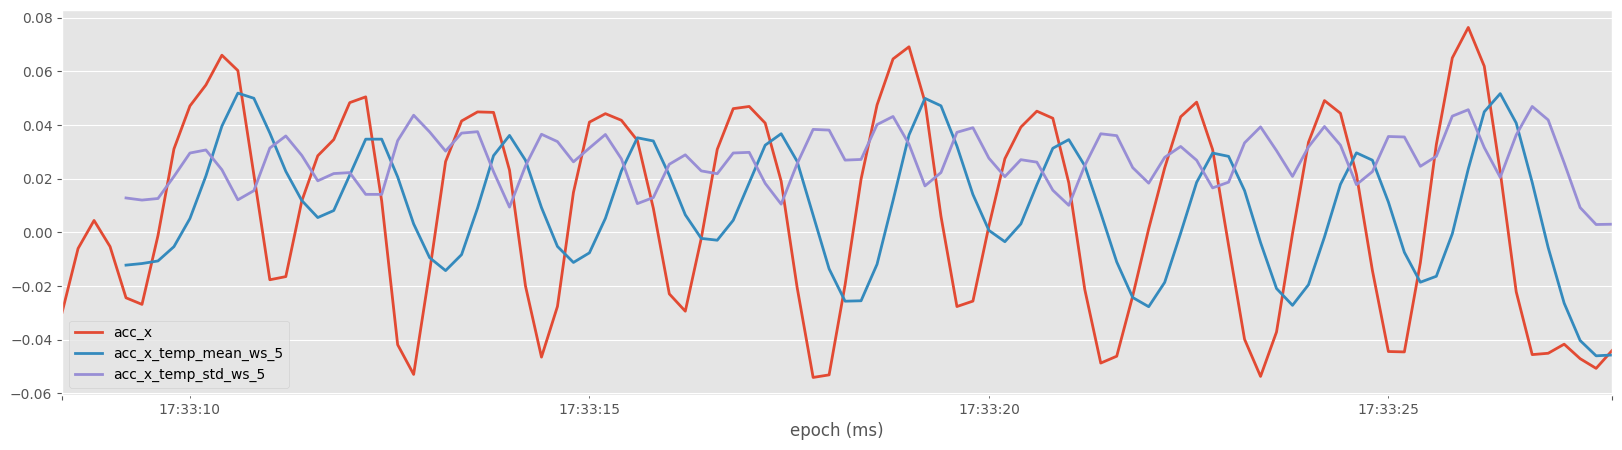

In [45]:
subset[["acc_x", "acc_x_temp_mean_ws_5", "acc_x_temp_std_ws_5"]].plot()

<AxesSubplot: xlabel='epoch (ms)'>

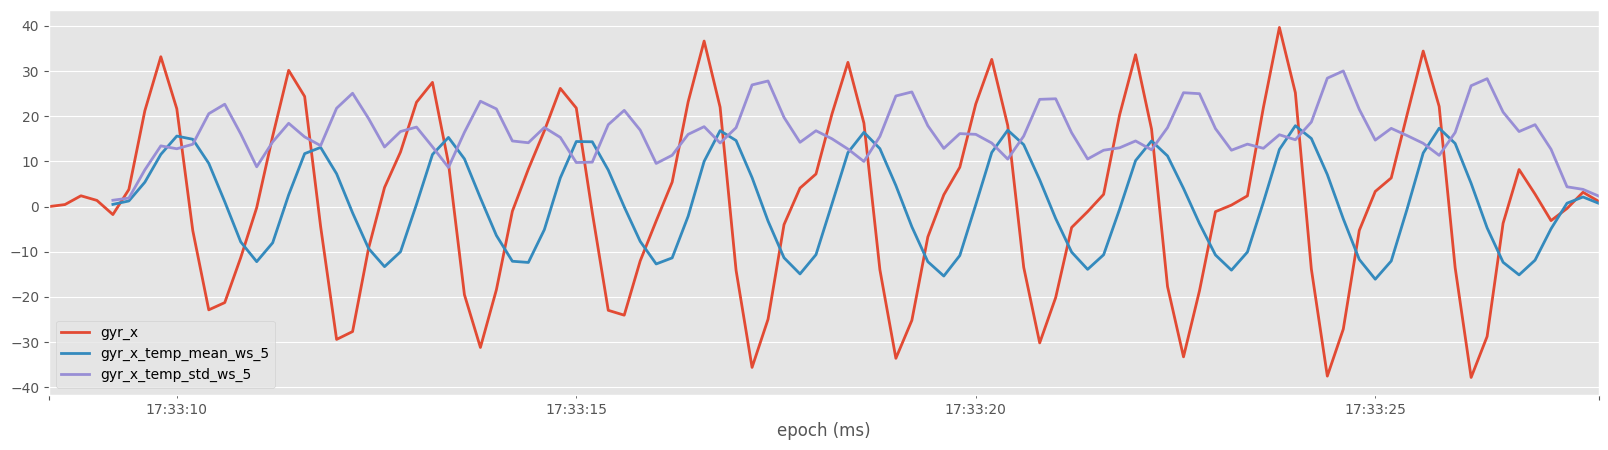

In [46]:
subset[["gyr_x", "gyr_x_temp_mean_ws_5", "gyr_x_temp_std_ws_5"]].plot()

In [47]:
df_freq = df_temporal.copy().reset_index()
FreqAbs = FourierTransformation()

fs = int(1000 / 200)
ws = int(2800 / 200)  # avg length of a repetition

df_freq = FreqAbs.abstract_frequency(df_freq, ["acc_y"], ws, fs)
df_freq.columns

Index(['epoch (ms)', 'acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z',
       'participant', 'label', 'category', 'set', 'duration', 'pca_1', 'pca_2',
       'pca_3', 'acc_r', 'gyr_r', 'acc_x_temp_mean_ws_5',
       'acc_x_temp_std_ws_5', 'acc_y_temp_mean_ws_5', 'acc_y_temp_std_ws_5',
       'acc_z_temp_mean_ws_5', 'acc_z_temp_std_ws_5', 'gyr_x_temp_mean_ws_5',
       'gyr_x_temp_std_ws_5', 'gyr_y_temp_mean_ws_5', 'gyr_y_temp_std_ws_5',
       'gyr_z_temp_mean_ws_5', 'gyr_z_temp_std_ws_5', 'acc_r_temp_mean_ws_5',
       'acc_r_temp_std_ws_5', 'gyr_r_temp_mean_ws_5', 'gyr_r_temp_std_ws_5',
       'acc_y_max_freq', 'acc_y_freq_weighted', 'acc_y_pse',
       'acc_y_freq_0.0_Hz_ws_14', 'acc_y_freq_0.357_Hz_ws_14',
       'acc_y_freq_0.714_Hz_ws_14', 'acc_y_freq_1.071_Hz_ws_14',
       'acc_y_freq_1.429_Hz_ws_14', 'acc_y_freq_1.786_Hz_ws_14',
       'acc_y_freq_2.143_Hz_ws_14', 'acc_y_freq_2.5_Hz_ws_14'],
      dtype='object')

<AxesSubplot: >

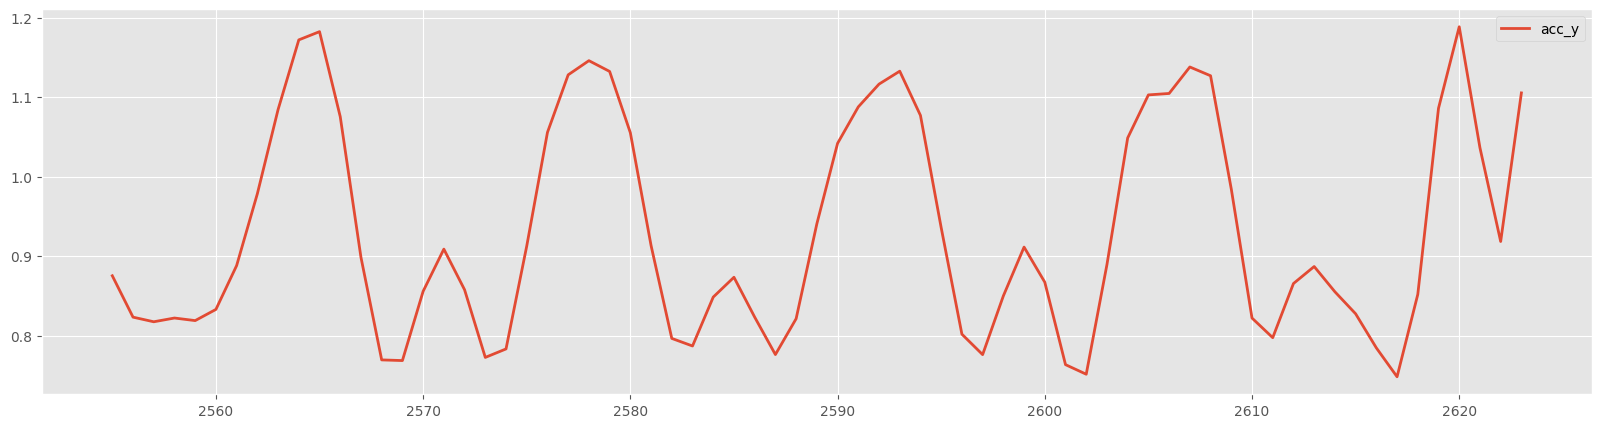

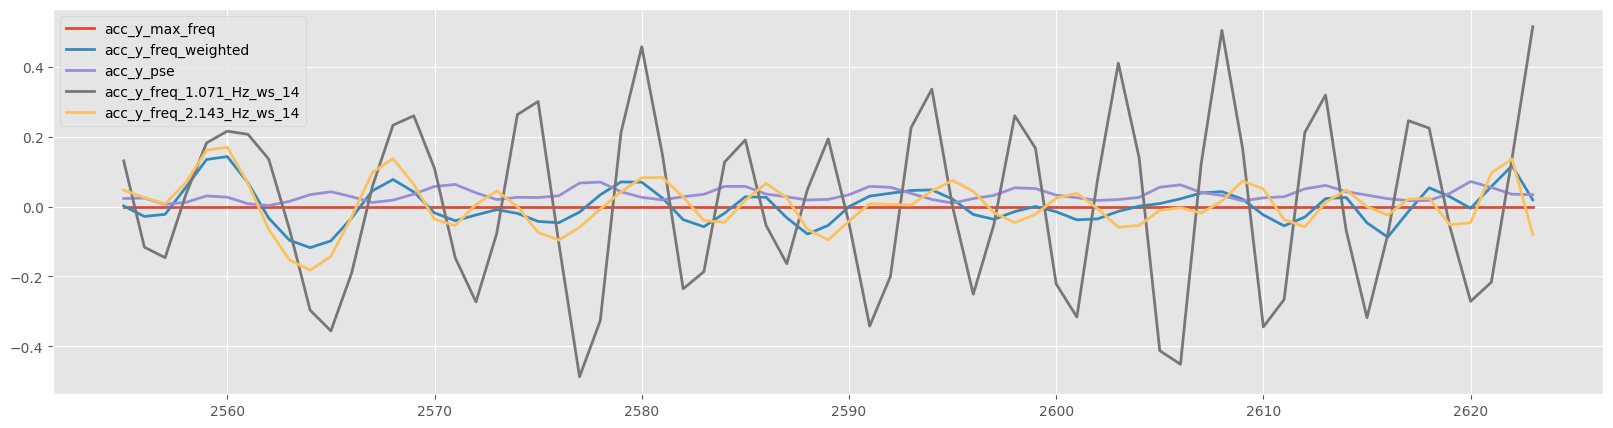

In [48]:
subset = df_freq[df_freq["set"] == 12]
subset[["acc_y"]].plot()
subset[
    [
        "acc_y_max_freq",
        "acc_y_freq_weighted",
        "acc_y_pse",
        "acc_y_freq_1.071_Hz_ws_14",
        "acc_y_freq_2.143_Hz_ws_14",
    ]
].plot()

In [50]:
df_freq_list = []
for s in df_freq["set"].unique():
    print(f"Applying fourier transformation to set {s}:")
    subset = (
        df_freq[df_freq["set"] == s].reset_index(drop=True).copy()
    )  # you should reset
    subset = FreqAbs.abstract_frequency(subset, predictor_columns, ws, fs)
    df_freq_list.append(subset)

df_freq = pd.concat(df_freq_list).set_index("epoch (ms)", drop=True)

Applying fourier transformation to set 30:
Applying fourier transformation to set 1:
Applying fourier transformation to set 31:
Applying fourier transformation to set 3:
Applying fourier transformation to set 9:
Applying fourier transformation to set 32:
Applying fourier transformation to set 10:
Applying fourier transformation to set 33:
Applying fourier transformation to set 11:
Applying fourier transformation to set 34:
Applying fourier transformation to set 35:
Applying fourier transformation to set 15:
Applying fourier transformation to set 36:
Applying fourier transformation to set 16:
Applying fourier transformation to set 37:
Applying fourier transformation to set 17:
Applying fourier transformation to set 27:
Applying fourier transformation to set 38:
Applying fourier transformation to set 28:
Applying fourier transformation to set 29:
Applying fourier transformation to set 6:
Applying fourier transformation to set 65:
Applying fourier transformation to set 67:
Applying fourie

<AxesSubplot: xlabel='epoch (ms)'>

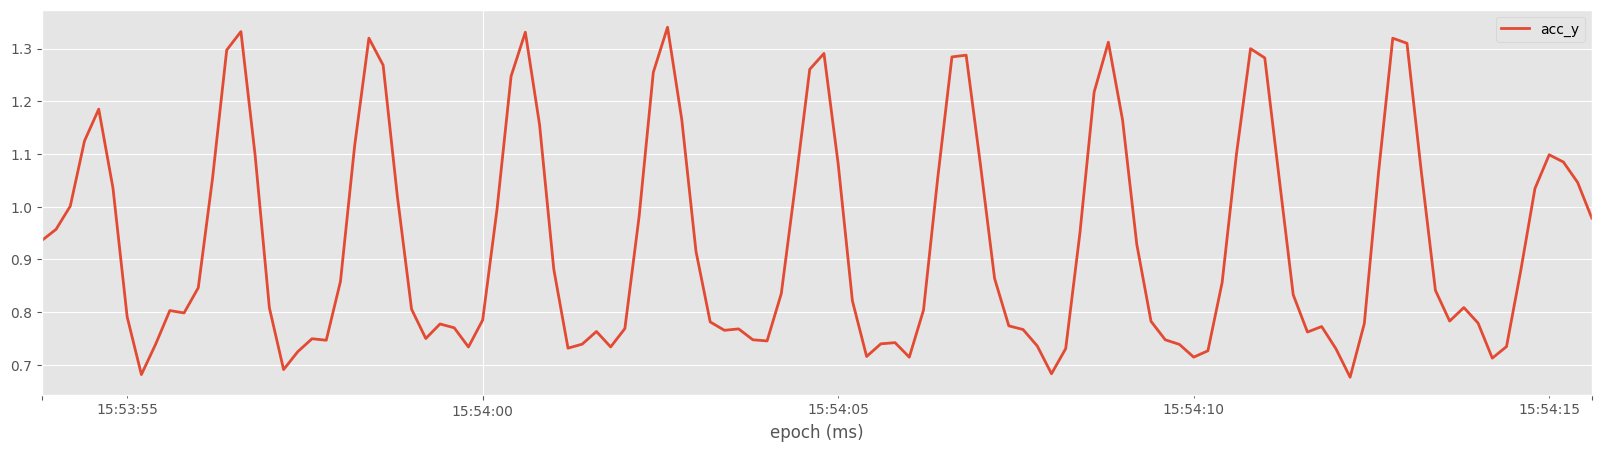

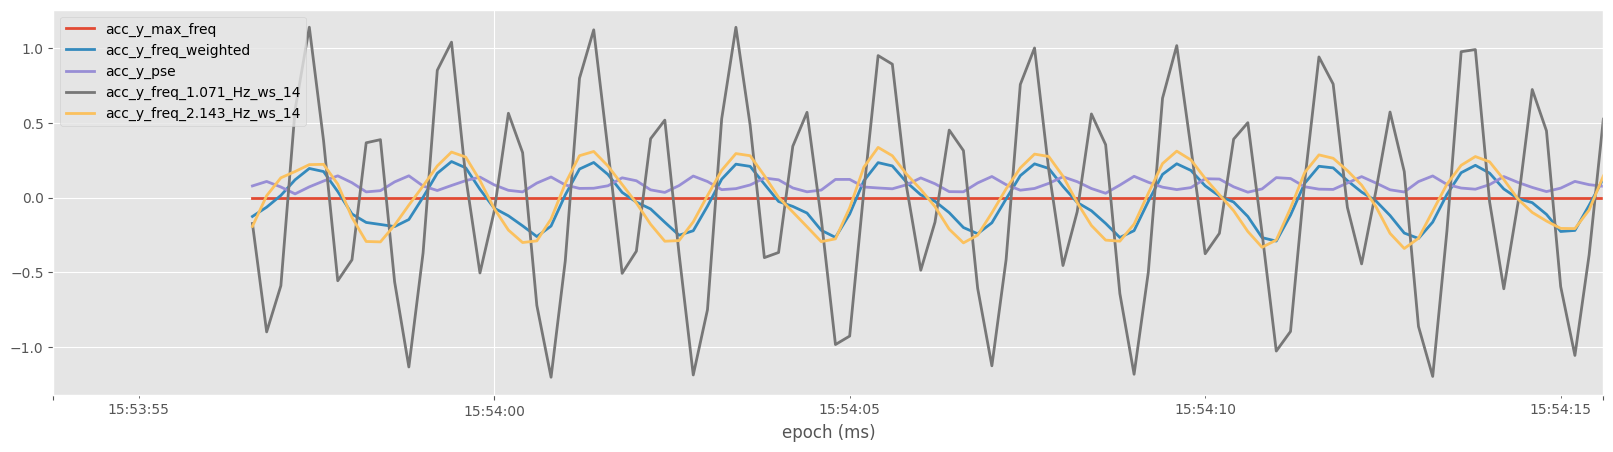

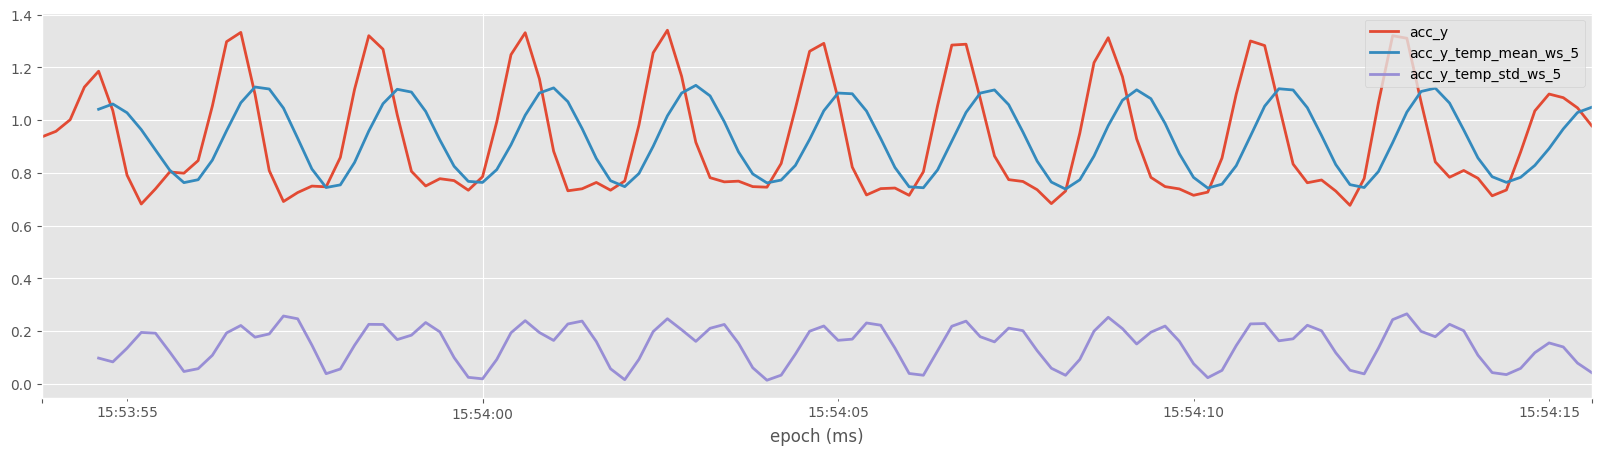

In [62]:
subset = df_freq[df_freq["set"] == 15]
subset[["acc_y"]].plot()
subset[
    [
        "acc_y_max_freq",
        "acc_y_freq_weighted",
        "acc_y_pse",
        "acc_y_freq_1.071_Hz_ws_14",
        "acc_y_freq_2.143_Hz_ws_14",
    ]
].plot()
subset[["acc_y", "acc_y_temp_mean_ws_5", "acc_y_temp_std_ws_5"]].plot()

In [63]:
df_freq

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_r_freq_weighted,gyr_r_pse,gyr_r_freq_0.0_Hz_ws_14,gyr_r_freq_0.357_Hz_ws_14,gyr_r_freq_0.714_Hz_ws_14,gyr_r_freq_1.071_Hz_ws_14,gyr_r_freq_1.429_Hz_ws_14,gyr_r_freq_1.786_Hz_ws_14,gyr_r_freq_2.143_Hz_ws_14,gyr_r_freq_2.5_Hz_ws_14
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013507,0.976994,-0.071005,-1.884434,2.438116,0.938372,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.400,0.008033,0.975262,-0.065866,1.536069,0.442310,-1.065650,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.600,-0.009115,0.964123,-0.072978,4.245043,-2.034491,-1.046461,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.800,-0.023861,0.960097,-0.085242,2.777774,-3.498659,0.601113,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:06.000,-0.020992,0.965676,-0.094796,0.923234,-1.313732,-2.085027,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.045042,-0.976448,-0.061903,2.748413,-4.307783,0.251154,E,row,medium,90,...,-0.264599,0.225127,317.621650,-33.331619,28.893434,9.980059,-1.078005,-50.328548,-0.748444,0.688502
2019-01-20 17:33:27.200,-0.041659,-1.037401,-0.060441,-3.112396,-2.260935,1.311641,E,row,medium,90,...,0.524651,0.634028,306.634543,-43.069853,61.414458,78.641085,-20.953296,60.428373,14.780129,9.046281
2019-01-20 17:33:27.400,-0.047054,-1.050451,-0.066066,-0.430802,-1.881234,1.141422,E,row,medium,90,...,0.628804,0.560975,267.062819,-70.524379,37.803609,37.381576,20.581915,20.673143,19.834997,31.308395


In [64]:
df_freq = df_freq.dropna()
df_freq = df_freq.iloc[::2]

In [65]:
df_freq

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_r_freq_weighted,gyr_r_pse,gyr_r_freq_0.0_Hz_ws_14,gyr_r_freq_0.357_Hz_ws_14,gyr_r_freq_0.714_Hz_ws_14,gyr_r_freq_1.071_Hz_ws_14,gyr_r_freq_1.429_Hz_ws_14,gyr_r_freq_1.786_Hz_ws_14,gyr_r_freq_2.143_Hz_ws_14,gyr_r_freq_2.5_Hz_ws_14
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:08.000,-0.170589,0.892267,-0.170867,-26.845376,-10.337435,25.884281,B,bench,heavy,30,...,-1.127687,0.398177,233.776838,-30.435868,17.847492,-1.965297,-24.466852,12.436928,-54.021700,-12.124224
2019-01-11 15:08:08.400,-0.026943,0.874179,-0.057250,-3.439846,-1.785081,2.641767,B,bench,heavy,30,...,-0.195190,0.376409,259.903047,-37.890347,-66.582261,-16.027255,7.061419,16.191004,5.206956,-1.743751
2019-01-11 15:08:08.800,-0.061235,0.986906,-0.035533,2.845038,-1.432343,-2.098136,B,bench,heavy,30,...,-0.606259,0.460699,258.979632,-46.945478,-29.577920,3.656968,-12.117559,-50.138834,36.612704,-11.242312
2019-01-11 15:08:09.200,-0.046792,0.978801,-0.036753,0.597036,-3.822361,4.563470,B,bench,heavy,30,...,0.468821,0.488154,251.092240,-31.885615,66.255509,5.333057,15.450696,37.774901,26.255166,-6.819488
2019-01-11 15:08:09.600,-0.045576,0.906516,-0.057210,10.418365,5.008932,-9.778520,B,bench,heavy,30,...,-0.453838,0.388942,213.194022,-15.926719,18.342209,10.709572,8.837472,23.634115,-34.601700,-34.299045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:26.200,0.061905,-0.929998,0.110785,-37.837668,8.252645,15.234692,E,row,medium,90,...,-1.318411,0.344110,363.811139,27.132352,-53.746661,12.406894,-48.473599,-35.556241,-18.693844,-35.945594
2019-01-20 17:33:26.600,-0.022139,-1.210564,-0.110940,-3.701006,-1.351086,6.098735,E,row,medium,90,...,0.460426,0.313800,375.084736,37.871967,-19.390934,-15.444639,28.236098,77.581212,23.795192,10.167371
2019-01-20 17:33:27.000,-0.045042,-0.976448,-0.061903,2.748413,-4.307783,0.251154,E,row,medium,90,...,-0.264599,0.225127,317.621650,-33.331619,28.893434,9.980059,-1.078005,-50.328548,-0.748444,0.688502


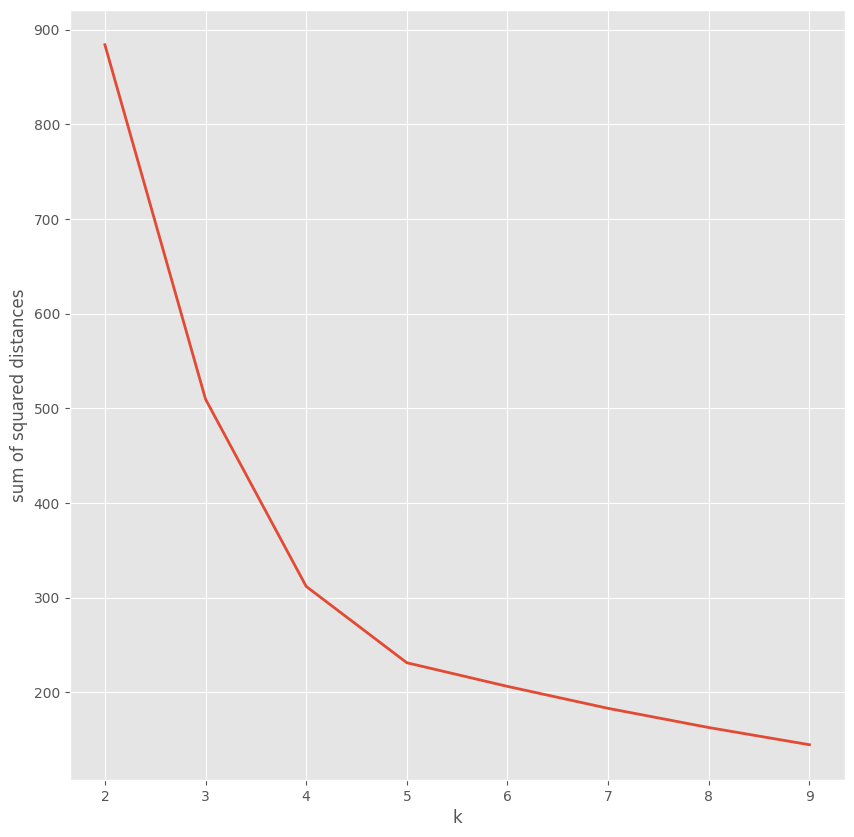

In [66]:
df_cluster = df_freq.copy()
cluster_columns = ["acc_x", "acc_y", "acc_z"]
k_values = range(2, 10)
inertias = []

for k in k_values:
    subset = df_cluster[cluster_columns]
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=0)
    cluster_labels = kmeans.fit_predict(subset)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 10))
plt.plot(k_values, inertias)
plt.xlabel("k")
plt.ylabel("sum of squared distances")
plt.show()

In [67]:
subset = df_cluster[cluster_columns]
kmeans = KMeans(n_clusters=5, n_init=20, random_state=0)
df_cluster["cluster"] = kmeans.fit_predict(subset)

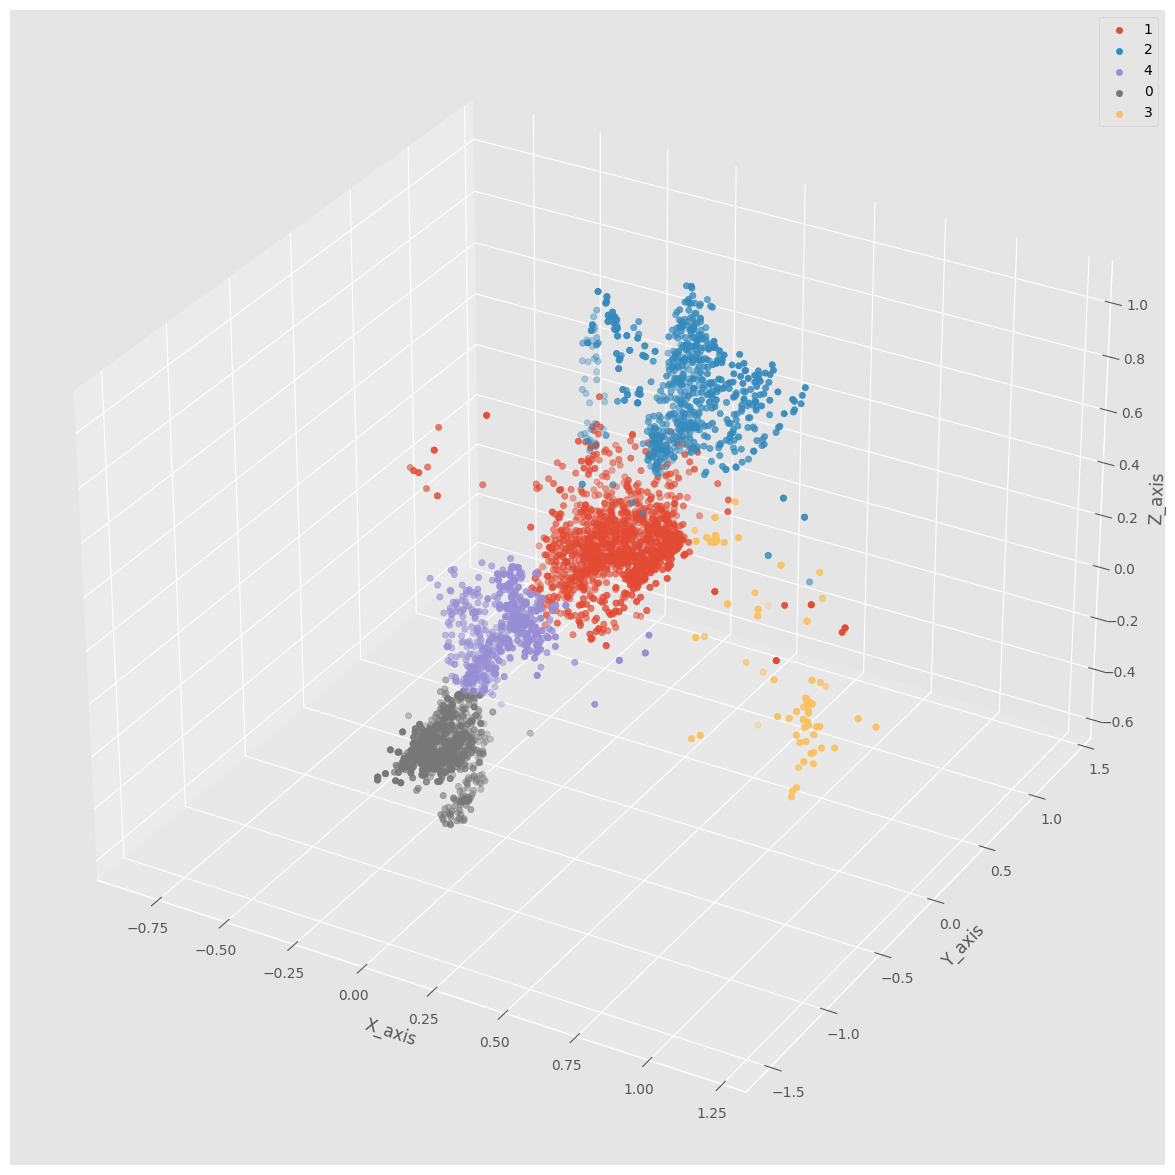

In [68]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection="3d")
for c in df_cluster["cluster"].unique():
    subset = df_cluster[df_cluster["cluster"] == c]
    ax.scatter(subset["acc_x"], subset["acc_y"], subset["acc_z"], label=c)
ax.set_xlabel("X_axis")
ax.set_ylabel("Y_axis")
ax.set_zlabel("Z_axis")
plt.legend()
plt.show()

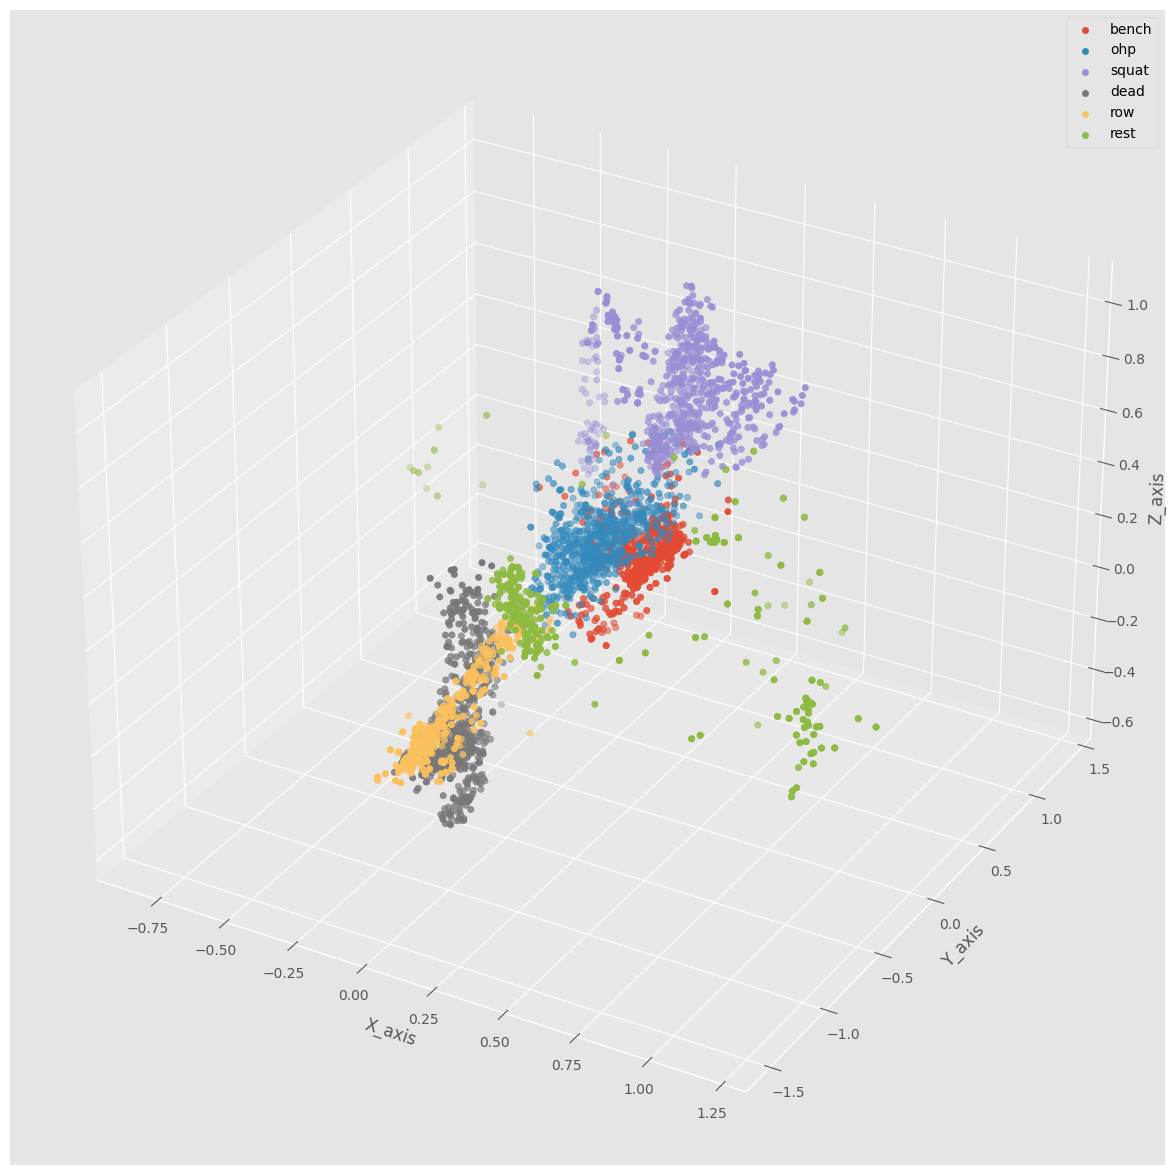

In [69]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection="3d")
for label in df_cluster["label"].unique():
    subset = df_cluster[df_cluster["label"] == label]
    ax.scatter(subset["acc_x"], subset["acc_y"], subset["acc_z"], label=label)
ax.set_xlabel("X_axis")
ax.set_ylabel("Y_axis")
ax.set_zlabel("Z_axis")
plt.legend()
plt.show()

In [70]:
df_cluster.to_pickle("../../data/interim/03_data_features.pkl")

In [71]:
df_cluster

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_r_pse,gyr_r_freq_0.0_Hz_ws_14,gyr_r_freq_0.357_Hz_ws_14,gyr_r_freq_0.714_Hz_ws_14,gyr_r_freq_1.071_Hz_ws_14,gyr_r_freq_1.429_Hz_ws_14,gyr_r_freq_1.786_Hz_ws_14,gyr_r_freq_2.143_Hz_ws_14,gyr_r_freq_2.5_Hz_ws_14,cluster
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:08.000,-0.170589,0.892267,-0.170867,-26.845376,-10.337435,25.884281,B,bench,heavy,30,...,0.398177,233.776838,-30.435868,17.847492,-1.965297,-24.466852,12.436928,-54.021700,-12.124224,1
2019-01-11 15:08:08.400,-0.026943,0.874179,-0.057250,-3.439846,-1.785081,2.641767,B,bench,heavy,30,...,0.376409,259.903047,-37.890347,-66.582261,-16.027255,7.061419,16.191004,5.206956,-1.743751,1
2019-01-11 15:08:08.800,-0.061235,0.986906,-0.035533,2.845038,-1.432343,-2.098136,B,bench,heavy,30,...,0.460699,258.979632,-46.945478,-29.577920,3.656968,-12.117559,-50.138834,36.612704,-11.242312,1
2019-01-11 15:08:09.200,-0.046792,0.978801,-0.036753,0.597036,-3.822361,4.563470,B,bench,heavy,30,...,0.488154,251.092240,-31.885615,66.255509,5.333057,15.450696,37.774901,26.255166,-6.819488,1
2019-01-11 15:08:09.600,-0.045576,0.906516,-0.057210,10.418365,5.008932,-9.778520,B,bench,heavy,30,...,0.388942,213.194022,-15.926719,18.342209,10.709572,8.837472,23.634115,-34.601700,-34.299045,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:26.200,0.061905,-0.929998,0.110785,-37.837668,8.252645,15.234692,E,row,medium,90,...,0.344110,363.811139,27.132352,-53.746661,12.406894,-48.473599,-35.556241,-18.693844,-35.945594,4
2019-01-20 17:33:26.600,-0.022139,-1.210564,-0.110940,-3.701006,-1.351086,6.098735,E,row,medium,90,...,0.313800,375.084736,37.871967,-19.390934,-15.444639,28.236098,77.581212,23.795192,10.167371,0
2019-01-20 17:33:27.000,-0.045042,-0.976448,-0.061903,2.748413,-4.307783,0.251154,E,row,medium,90,...,0.225127,317.621650,-33.331619,28.893434,9.980059,-1.078005,-50.328548,-0.748444,0.688502,0


In [72]:
cluster_labels = kmeans.labels_

In [73]:
cluster_labels

array([1, 1, 1, ..., 0, 0, 0])

In [74]:
from sklearn.metrics import silhouette_score

In [77]:
subset

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_r_pse,gyr_r_freq_0.0_Hz_ws_14,gyr_r_freq_0.357_Hz_ws_14,gyr_r_freq_0.714_Hz_ws_14,gyr_r_freq_1.071_Hz_ws_14,gyr_r_freq_1.429_Hz_ws_14,gyr_r_freq_1.786_Hz_ws_14,gyr_r_freq_2.143_Hz_ws_14,gyr_r_freq_2.5_Hz_ws_14,cluster
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-18 17:22:29.000,0.918267,-0.128026,0.304230,-3.504334,6.313732,5.411510,A,rest,sitting,18,...,0.606561,199.835465,-55.872752,-40.806187,49.332428,-7.138560,-3.871559,-4.559845,2.157828,3
2019-01-18 17:22:29.400,0.828999,-0.140276,0.488769,-9.211948,43.577199,16.992423,A,rest,sitting,18,...,0.468374,272.365366,56.521706,-33.412910,-41.246701,-28.074537,-12.881766,-25.875927,-14.736232,3
2019-01-18 17:22:29.800,0.758793,-0.342890,0.643657,-9.987250,6.072993,0.786309,A,rest,sitting,18,...,0.382663,308.469204,88.742935,-8.166056,-45.193917,10.624121,-5.215821,2.410431,9.110879,3
2019-01-18 17:22:30.200,0.684656,-0.400149,0.625473,-1.097202,1.542625,10.708924,A,rest,sitting,18,...,0.486585,258.028402,-14.971869,-18.610401,87.417274,-0.408686,17.318949,24.174432,23.965922,3
2019-01-18 17:22:30.600,0.638203,-0.408153,0.618310,5.428099,-3.584623,0.120559,A,rest,sitting,18,...,0.705450,231.478719,-79.765575,51.823115,-50.679358,27.658816,2.893275,-0.082945,3.223693,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:26:18.000,0.157351,-0.842374,0.472725,-0.424310,10.891853,-2.102917,E,rest,standing,82,...,0.309808,409.631975,-53.554098,83.248896,-7.249764,2.353236,44.738998,-2.182188,4.958134,4
2019-01-20 17:26:18.400,0.188270,-0.854149,0.550308,-13.417839,31.537289,-12.807424,E,rest,standing,82,...,0.206377,400.663082,-59.233007,26.422261,18.655880,-3.934315,-37.790897,-16.725035,1.162863,4
2019-01-20 17:26:18.800,0.198440,-0.892027,0.426226,-4.669735,19.868632,-23.402162,E,rest,standing,82,...,0.169755,433.799629,8.723049,-72.906097,-26.075452,-7.339955,-16.476521,-6.860637,7.487935,4


In [78]:
subset = df_cluster[cluster_columns]

In [79]:
kmeans = KMeans(n_clusters=5, n_init=20, random_state=0)

In [80]:
df_cluster["cluster"] = kmeans.fit_predict(subset)

In [81]:
silhouette_avg = silhouette_score(subset, cluster_labels)

In [82]:
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.5856773497535777


In [83]:
unique, counts = np.unique(cluster_labels, return_counts=True)

In [85]:
percentage_distribution = counts / len(subset) * 100

In [86]:
for cluster, percentage in zip(unique, percentage_distribution):
    print(f"Cluster {cluster}: {percentage:.2f}%")

Cluster 0: 22.47%
Cluster 1: 37.13%
Cluster 2: 18.25%
Cluster 3: 5.27%
Cluster 4: 16.88%
